# OpenCVとDlibを用いた画像認識 ｰデータ分析ｰ

以下のコードを参考に、画像認識で得たデータの活用を理解してください。
各教材を解きながら、データの加工や可視化、データ分析の流れを学んでください。

### 人通りの変化をグラフで確認する

In [1]:
import cv2
import pandas as pd

print("分析を開始します")

# 動画ファイルの読み込み
cap = cv2.VideoCapture("vtest.avi")

# 動画のフレームレート（FPS）を取得
fps = cap.get(cv2.CAP_PROP_FPS)

# HOG（Histogram of Oriented Gradients）人物検出器の設定
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {
    'winStride': (4, 4),    # 検出ウィンドウの移動ステップ
    'padding': (8, 8),      # 検出ウィンドウの周りのパディング
    'scale': 1.05,          # 画像ピラミッドのスケール
    'hitThreshold': 0,      # 検出閾値
    'finalThreshold': 5     # 重複検出のフィルタリング閾値
}

num = 0  # フレームカウンター
# 結果を格納するためのデータフレームを初期化
list_df = pd.DataFrame(columns=['time', 'people'])

while(cap.isOpened()):
    ret, frame = cap.read()  # フレームを1つ読み込む
    if ret:
        if (num % 10 == 0):  # 10フレームごとに処理
            # グレースケールに変換（人物検出の精度向上のため）
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # 人物検出を実行
            human, r = hog.detectMultiScale(gray, **hogParams)
            
            if (len(human) > 0):  # 人物が検出された場合
                for (x, y, w, h) in human:
                    # 検出された人物を白い矩形で囲む
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)
            
            # 時間と検出された人数をデータフレームに追加
            tmp_se = pd.Series([num/fps, len(human)], index=list_df.columns)
            list_df = list_df.append(tmp_se, ignore_index=True)
            
            # 検出結果を表示
            cv2.imshow('frame', frame)
            # 'q'キーが押されたらループを終了
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break  # 動画の終わりに達したらループを終了
    
    num += 1  # フレームカウンターを増加

# リソースの解放
cap.release()
cv2.destroyAllWindows()

print("分析を終了しました")
# この時点で list_df には時間と検出された人数のデータが格納されています

分析を開始します
分析を終了しました


### グラフプロット 

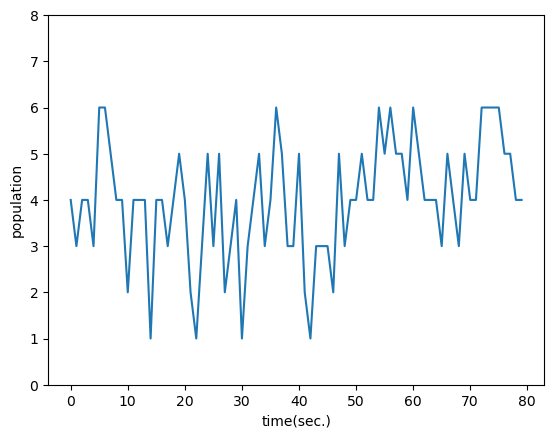

In [2]:
# matplotlib ライブラリをインポート
import matplotlib.pyplot as plt

# list_dfは既に存在すると仮定します

# 時間と人数のグラフを作成
plt.plot(list_df["time"], list_df["people"])

# X軸のラベルを設定
plt.xlabel('time(sec.)')

# Y軸のラベルを設定
plt.ylabel('population')

# Y軸の範囲を0から8に設定
plt.ylim(0, 8)

# グラフを表示
plt.show()

### PELTアルゴリズムを用いた変化点検出

検出された変化点のインデックス: [20, 50, 80]


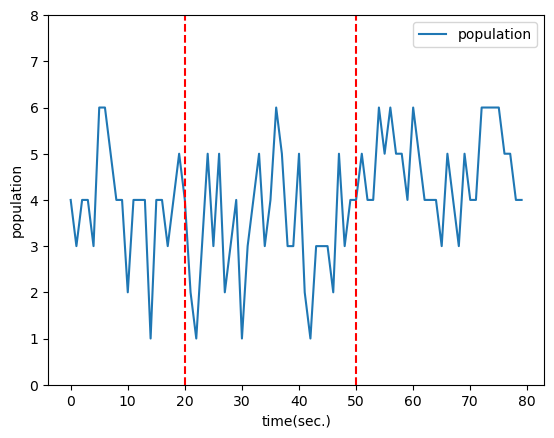

In [10]:
import ruptures as rpt
import matplotlib.pyplot as plt

# list_dfは既に存在すると仮定します

# 人数データを抽出
signal = list_df['people'].values

# モデルの選択（"l1", "l2", "rbf"など）
model = "l1"

# PELTアルゴリズムを使用して変化点検出を実行
algo = rpt.Pelt(model=model).fit(signal)

# ペナルティ値の設定（変化点の数を調整）
penalty = 3  # 必要に応じて調整

# 変化点のインデックスを取得
result = algo.predict(pen=penalty)

# 検出された変化点を表示
print("検出された変化点のインデックス:", result)

# 時間と人数のプロットを作成し、変化点を表示
plt.plot(list_df['time'], signal, label='population')

# 検出された変化点に垂直線を引く
for cp in result[:-1]:  # 最後のポイントは信号の終わりなので除外
    plt.axvline(x=list_df['time'].iloc[cp], color='red', linestyle='--')

plt.xlabel('time(sec.)')
plt.ylabel('population')
# Y軸の範囲を0から8に設定
plt.ylim(0, 8)
plt.legend()
plt.show()


### 移動平均を計算することでノイズの影響を除去する

In [ ]:
import numpy as np
def moving_average(x, y):
    y_conv = np.convolve(y, np.ones(5)/float(5), mode='valid')
    x_dat = np.linspace(np.min(x), np.max(x), np.size(y_conv))
    return x_dat, y_conv

In [ ]:
plt.plot(list_df["time"], list_df["people"], label="raw")
ma_x, ma_y = moving_average(list_df["time"], list_df["people"])
plt.plot(ma_x,ma_y, label="average")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,8)
plt.legend()
plt.show()

## 到達度確認

課題1：Webカメラの読み込みと人物検出
* Webカメラを読み込み、OpenCVを用いて人物検出を行い、検出した人数を時間とともに記録してみよう。
* Dlibを用いて動画内の顔を検出を行い、検出した顔数を時間とともに記録してみよう。
     
課題2：人数データの可視化
* 課題1で取得した人数および顔数データを用いて、時間に対する値の変化をグラフで表示してみよう。

課題3：データのCSV保存
* list_dfに記録されたきデータをCSVファイルに保存し、後からデータを再利用できるようにしてみよう。

## 応用課題

* 変化点検出アルゴリズムの比較
    * 目的：PELTアルゴリズム以外の変化点検出アルゴリズム（例えば、BinsegやBottomUpなど）を試し、検出結果を比較する。
* 人流データの統計分析
    * 目的：取得したデータからピーク時の人数や平均人数などの統計情報を算出し、時間帯による人流の傾向を分析する。
* 異なる環境でのデータ分析
    * 目的：別の動画データ（例えば、夜間の映像や異なる場所の映像）を用いて同様の分析を行い、環境の違いによる人流の変化を比較する。
* 集中度の評価
    * 目的：検出した顔の向きデータから、ユーザーが画面に対してどの程度集中しているかを分析し、一定時間以上画面から目を逸らしている場合に警告を表示するシステムを構築する。
* 顔向きと行動パターンの関連性
    * 目的：顔の向きと他の行動（例：キーボード入力やマウス操作）との関連性を調査し、生産性の指標として活用する方法を検討する。
* 顔表情の変化検出
    * 目的：Dlibや他のライブラリを用いて、動画内の人物の表情を解析し、感情の変化を時系列で可視化する。